## Data Pull


In [13]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import os

basket_1 = ["SNOW", "DDOG", "NET", "ESTC", "MDB"]

# Basket 2: Cloud Security (Next-Gen)
basket_2 = ["CRWD", "ZS", "PANW", "OKTA", "S"]

# Basket 3: Enterprise SaaS Platforms
basket_3 = ["CRM", "NOW", "WDAY", "TEAM", "HUBS"]

# Basket 4: Ad Tech (Programmatic)
basket_4 = ["TTD", "TRADE", "MGNI", "PUBM", "RAMP"]

# Basket 5: Analog Semiconductors
basket_5 = ["TXN", "ADI", "MCHP", "ON", "NXPI"]

# Basket 6: GPU/AI Accelerators
basket_6 = ["AMD", "NVDA", "AVGO", "MRVL", "QCOM"]

# Basket 7: Communication/Collaboration SaaS
basket_7 = ["ZM", "TWLO", "DOCU", "RNG", "FIVN"]

# Basket 8: Payments/Fintech
basket_8 = ["PYPL", "SQ", "BILL", "SHOP", "MELI"]

# Basket 9: DevOps/Developer Tools
basket_9 = ["GTLB", "FROG", "PD", "DOCN", "CFLT"]

# Basket 10: Networking Infrastructure
basket_10 = ["CSCO", "ANET", "CIEN", "JNPR", "VMW"]

# Basket 11: E-commerce Platforms (weaker grouping)
basket_11 = ["EBAY", "WIX", "BIGC", "AMZN", "U"]

# Basket 12: Security (Identity/Access)
basket_12 = ["SAIL", "VRNS", "CYBR", "TENB", "CHKP"]

# Basket 13: Semiconductor Equipment (MPWR doesn't fit perfectly)
basket_13 = ["LRCX", "KLAC", "AMAT", "ENTG", "MPWR"]

# Basket 14: Social/Consumer Content
basket_14 = ["META", "PINS", "SNAP", "SPOT", "ROKU"]

# Basket 15: Productivity/Work Management (weakest grouping)
basket_15 = ["ASAN", "SMAR", "DOMO", "VEEV", "PCTY"]

basket_15 = ["ASAN", "SMAR", "DOMO", "VEEV", "PCTY"]

basket_16 = ["NET", "DDOG", "FSLY"]


# All baskets in a list
all_baskets = [
    basket_1, basket_2, basket_3, basket_4, basket_5,
    basket_6, basket_7, basket_8, basket_9, basket_10,
    basket_11, basket_12, basket_13, basket_14, basket_15
]


In [14]:
import numpy as np

def get_price_data(tickers, period="1y", max_missing=25, log_prices=True):
           """Download and clean stock price data, save to CSV files"""
           try:
               print(f"Downloading data for {len(tickers)} stocks...")
               data = yf.download(tickers, period=period)

               # Clean missing data
               close_missing = data["Close"].isnull().sum()
               stocks_to_drop = close_missing[close_missing > max_missing].index.tolist()

               if stocks_to_drop:
                   print(f"Dropping {len(stocks_to_drop)} stocks with >{max_missing} missing values")
                   data = data.drop(stocks_to_drop, axis=1, level=1)

               # Save files
               data.to_csv("data.csv")
               # Simple summary
               remaining_stocks = len(data.columns.get_level_values(1).unique())
               print(f"Final dataset: {remaining_stocks} stocks")

               return data

           except Exception as e:
               print(f"Error downloading data: {e}")
               return None

clean_data = get_price_data(basket_1, max_missing=25)

def get_close_price_data(tickers, period="1y", max_missing=25, log_prices=True):
        try:
            print(f"Downloading close prices for {len(tickers)} stocks...")
            data = yf.download(tickers, period=period)
            close_data = data["Close"]
            missing = close_data.isnull().sum()
            close_data = close_data.drop(missing[missing > max_missing].index, axis=1)
            close_data = close_data.ffill()
        
            if log_prices:
                close_data = np.log(close_data)
        
            filename = "_".join(tickers) + ".csv"
            close_data.to_csv(filename)
        
            print(f"Final dataset: {len(close_data.columns)} stocks")
            return close_data
        
        except Exception as e:
            print(f"Error: {e}")
            return None


close_data = get_close_price_data(basket_1, max_missing=25)
      


C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks


## Data Retrieval For Each Basket:

In [15]:
''' I need data for each basket, I can run a for loop across my function or make a new one'''

def get_all_close_data(tickers_super_list):
    for baskets in tickers_super_list:
        get_close_price_data(baskets, max_missing=25)

get_all_close_data(all_baskets)
    

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks
Final dataset: 5 stocks



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

1 Failed download:
['TRADE']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 4 stocks



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)


Final dataset: 5 stocks


[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

Final dataset: 5 stocks


[*********************100%***********************]  4 of 5 completed

1 Failed download:
['RNG']: Timeout('Failed to perform, curl: (28) Connection timed out after 10010 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

Final dataset: 4 stocks


[*********************100%***********************]  5 of 5 completed

1 Failed download:
['SQ']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)


Final dataset: 4 stocks


[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*******************   40%                       ]  2 of 5 completed

Final dataset: 5 stocks


[*********************100%***********************]  5 of 5 completed

2 Failed downloads:
['JNPR', 'VMW']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[                       0%                       ]

Final dataset: 3 stocks


[*********************100%***********************]  5 of 5 completed

1 Failed download:
['BIGC']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)


Final dataset: 4 stocks
Final dataset: 4 stocks


[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)


Final dataset: 5 stocks
Final dataset: 5 stocks


[*********************100%***********************]  5 of 5 completed

1 Failed download:
['SMAR']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 4 stocks


## Johansen Cointegration Testing On Baskets:

In [16]:

def load_all_csv(folder_path="."):
    '''load all CSVs from folder into a dictionary of DataFrames'''
    dfs = {}
    for file in os.listdir(folder_path):
        if file.endswith('.csv') and '_' in file and file != 'data.csv':
            basket_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(folder_path, file), index_col=0)
            dfs[basket_name] = df
    return dfs

all_data = load_all_csv()


def run_johansen(df):
    """Run Johansen cointegration test on a basket"""
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    
    print("Trace Statistics:", result.lr1)
    print("Critical Values (95%):", result.cvt[:, 1])
    print("\nCointegrating relationships:", sum(result.lr1 > result.cvt[:, 1]))
    
    return result


def test_all_baskets(all_data, crit_level=0):
    """
    crit_level: 0=90%, 1=95%, 2=99%
    """
    for name, df in all_data.items():
        print(f"\n{name}")
        result = coint_johansen(df, det_order=0, k_ar_diff=5)
        n_coint = sum(result.lr1 > result.cvt[:, crit_level])
        print(n_coint)

test_all_baskets(all_data)


AMD_NVDA_AVGO_MRVL_QCOM
0

ASAN_SMAR_DOMO_VEEV_PCTY
0

CRM_NOW_WDAY_TEAM_HUBS
1

CRWD_ZS_PANW_OKTA_S
0

CSCO_ANET_CIEN_JNPR_VMW
0

EBAY_WIX_BIGC_AMZN_U
0

GTLB_FROG_PD_DOCN_CFLT
2

LRCX_KLAC_AMAT_ENTG_MPWR
0

META_PINS_SNAP_SPOT_ROKU
1

NET_CFLT
0

NET_DDOG
0

NET_MDB
0

NET_SNOW
1

PYPL_SQ_BILL_SHOP_MELI
0

SAIL_VRNS_CYBR_TENB_CHKP
3

SNOW_DDOG_NET_ESTC_MDB
1

TTD_TRADE_MGNI_PUBM_RAMP
0

TXN_ADI_MCHP_ON_NXPI
1

ZM_TWLO_DOCU_RNG_FIVN
0


In [17]:
def test_new_basket(tickers, period="1y", k_ar_diff=5, crit_level=0):
    """Quick test for any new basket"""
    data = get_close_price_data(tickers, period=period)
    result = coint_johansen(data, det_order=0, k_ar_diff=k_ar_diff)
    n_coint = sum(result.lr1 > result.cvt[:, crit_level])
    
    print(f"{' '.join(tickers)}")
    print(f"Cointegrated: {n_coint}")
    
    if n_coint > 0:
        print("\nCointegrating vectors:")
        print(pd.DataFrame(
            result.evec[:, :n_coint], 
            index=data.columns,
            columns=[f"Vector_{i+1}" for i in range(n_coint)]
        ))
    
    return result


test_new_basket(["NET", "SNOW"])
test_new_basket(["NET", "DDOG"])
test_new_basket(["NET", "MDB"])
test_new_basket(["NET", "CFLT"])




C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

Final dataset: 2 stocks
NET SNOW
Cointegrated: 1

Cointegrating vectors:
         Vector_1
Ticker           
NET      9.302276
SNOW   -15.437431



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed

Final dataset: 2 stocks
NET DDOG
Cointegrated: 0



C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed
C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)


Final dataset: 2 stocks
NET MDB
Cointegrated: 0


[*********************100%***********************]  2 of 2 completed

Final dataset: 2 stocks
NET CFLT
Cointegrated: 0


C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed

Final dataset: 2 stocks


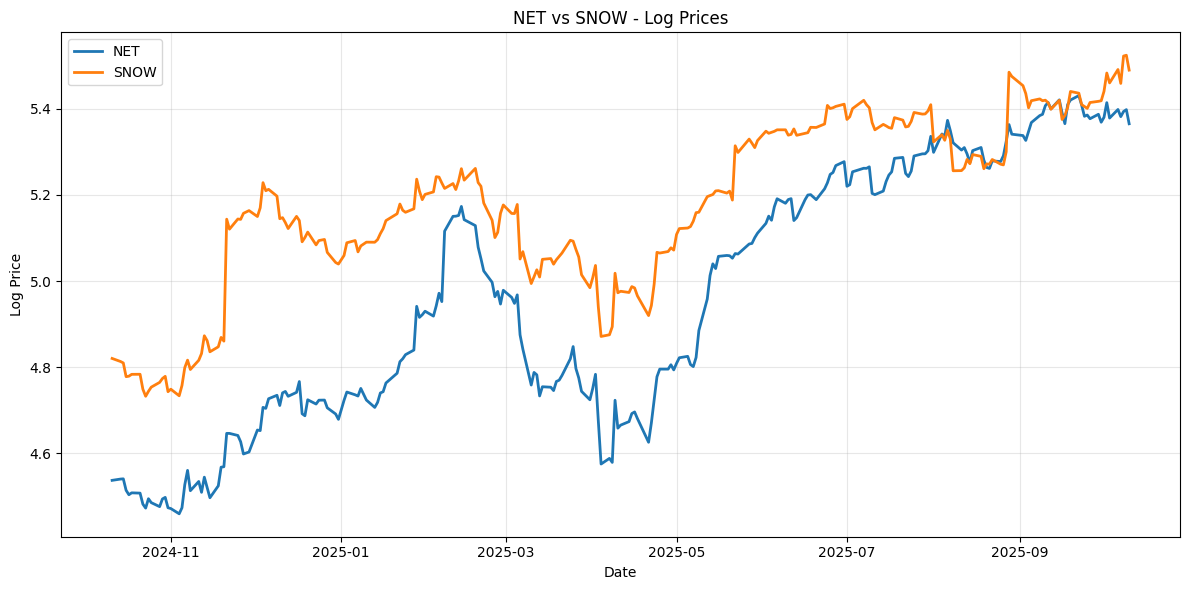

In [18]:
from matplotlib import pyplot as plt

net_snow = get_close_price_data(["NET", "SNOW"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(net_snow.index, net_snow['NET'], label='NET', linewidth=2)
plt.plot(net_snow.index, net_snow['SNOW'], label='SNOW', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.title('NET vs SNOW - Log Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed

Final dataset: 2 stocks
Basket: NET, DDOG
Cointegration rank: 0


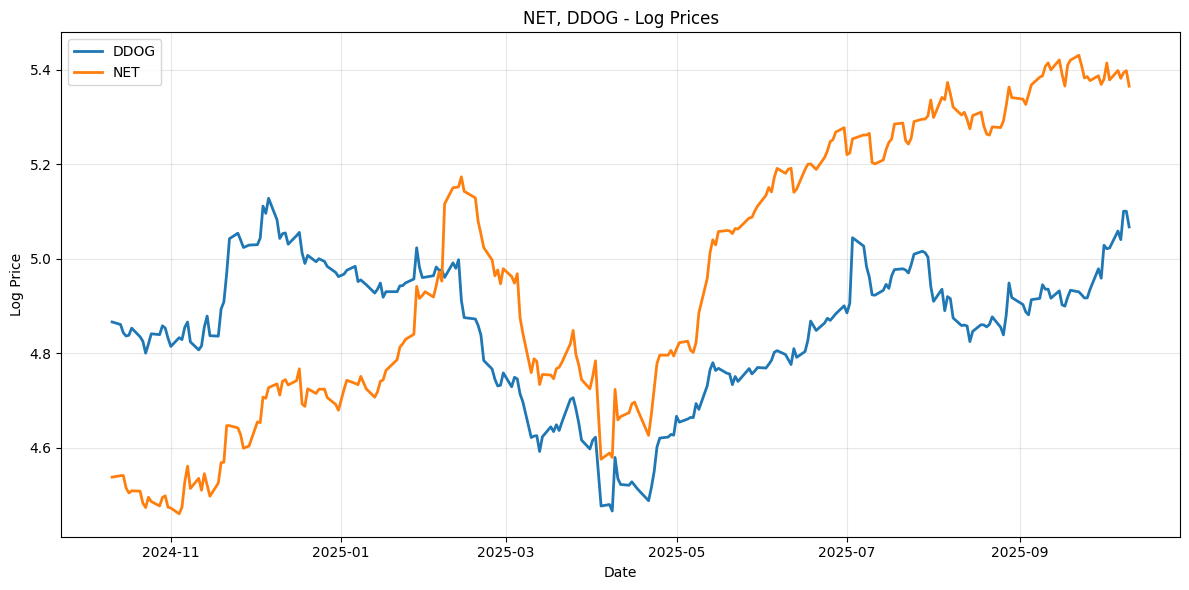

In [19]:
import matplotlib.pyplot as plt

def analyze_basket(tickers, period="1y", crit_level=1, k_ar_diff=5):
    """
    Complete cointegration analysis with visualization
    
    Parameters:
    tickers: list of stock tickers
    period: "6mo", "1y", "2y", etc
    crit_level: 0=90%, 1=95%, 2=99%
    k_ar_diff: lag length (default=5)
    """
    # Download data
    data = get_close_price_data(tickers, period=period)
    
    # Run Johansen test
    result = coint_johansen(data, det_order=0, k_ar_diff=k_ar_diff)
    n_coint = sum(result.lr1 > result.cvt[:, crit_level])
    
    # Print results
    print(f"Basket: {', '.join(tickers)}")
    print(f"Cointegration rank: {n_coint}")
    
    # Show vectors if cointegrated
    vectors = None
    if n_coint > 0:
        vectors = pd.DataFrame(
            result.evec[:, :n_coint],
            index=data.columns,
            columns=[f"Vector_{i+1}" for i in range(n_coint)]
        )
        print("\nCointegrating vectors:")
        print(vectors)
    
    # Plot
    plt.figure(figsize=(12, 6))
    for col in data.columns:
        plt.plot(data.index, data[col], label=col, linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.title(f"{', '.join(tickers)} - Log Prices")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return vectors

# Usage
analyze_basket(["NET", "DDOG", ])

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks
Basket: SNOW, DDOG, NET, ESTC, MDB
Cointegration rank: 1

Cointegrating vectors:
         Vector_1
Ticker           
DDOG     7.607558
ESTC    12.369256
MDB     -5.066652
NET     14.608631
SNOW   -23.704247


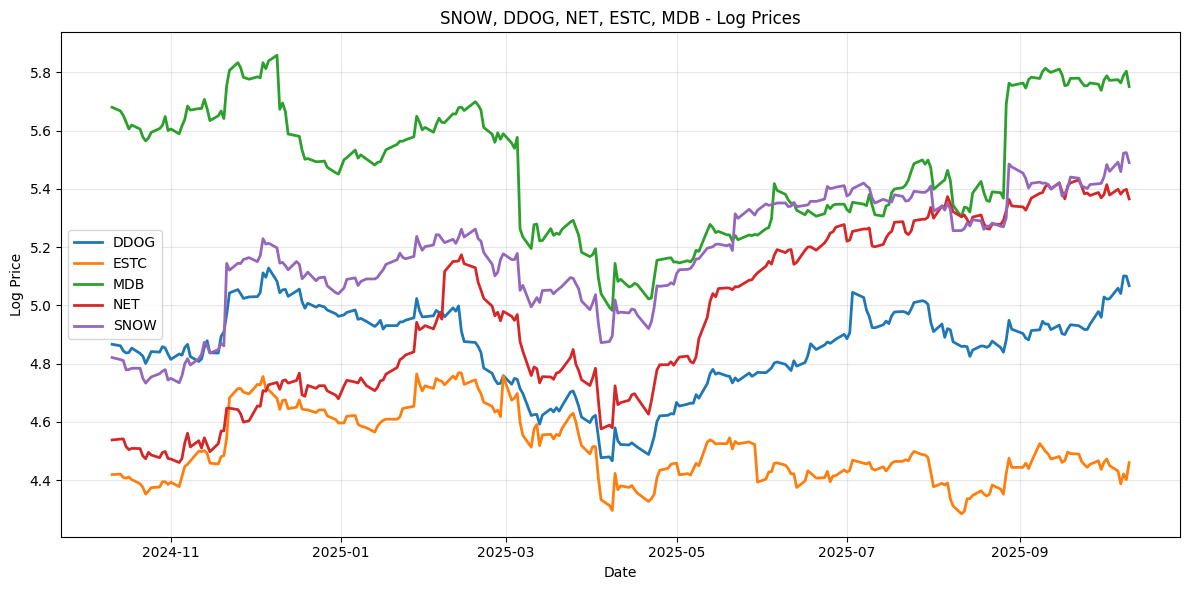

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 5 stocks
Basket: CRWD, ZS, PANW, OKTA, S
Cointegration rank: 0


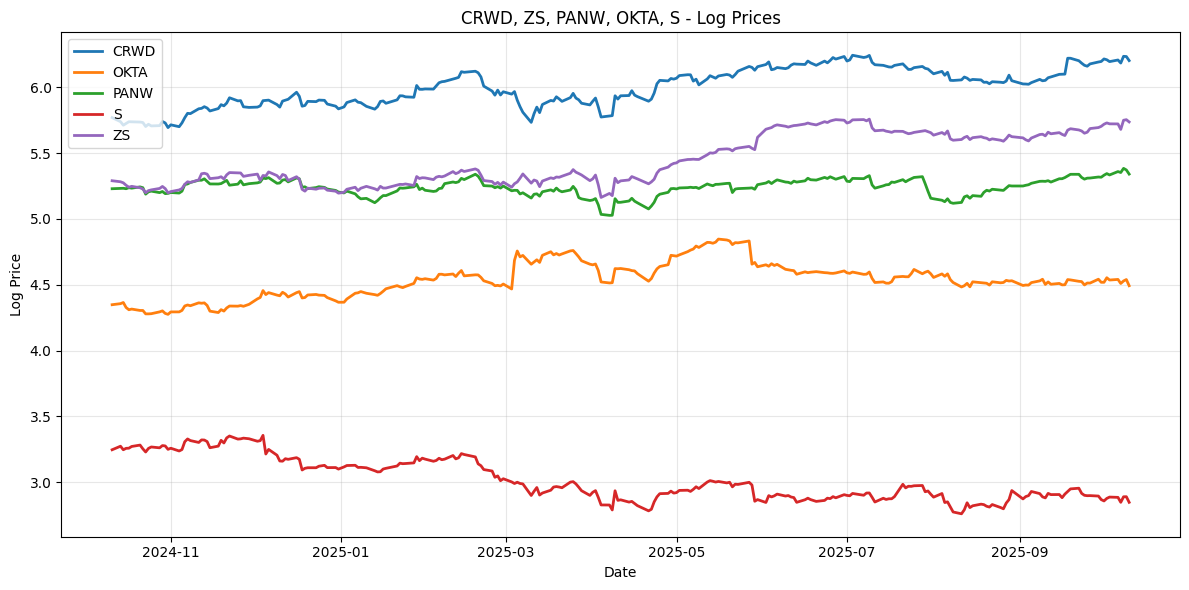

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed



Final dataset: 5 stocks
Basket: CRM, NOW, WDAY, TEAM, HUBS
Cointegration rank: 1

Cointegrating vectors:
         Vector_1
Ticker           
CRM      9.074922
HUBS    28.672336
NOW     -2.096407
TEAM   -19.174531
WDAY   -40.866801


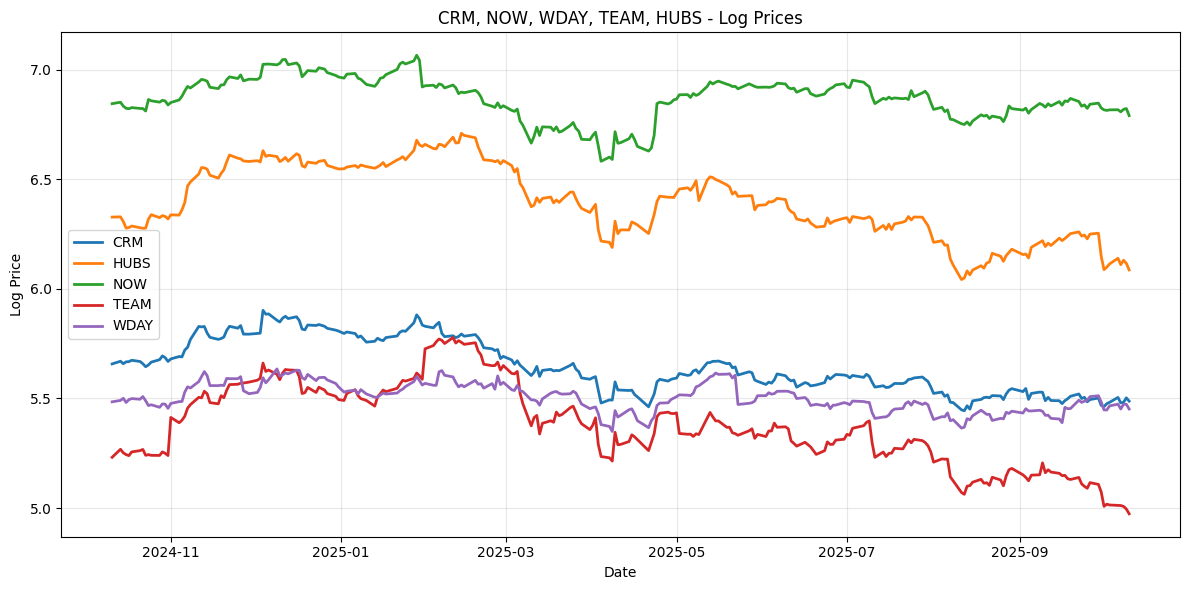

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

1 Failed download:
['TRADE']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 4 stocks
Basket: TTD, TRADE, MGNI, PUBM, RAMP
Cointegration rank: 0


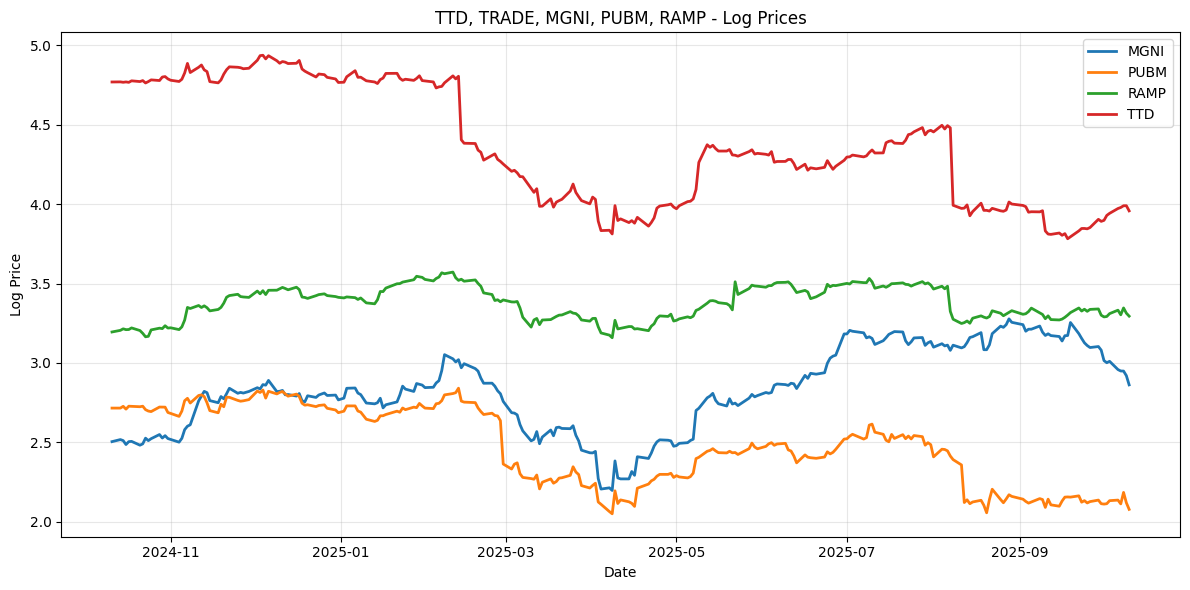

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed


Final dataset: 5 stocks
Basket: TXN, ADI, MCHP, ON, NXPI
Cointegration rank: 0


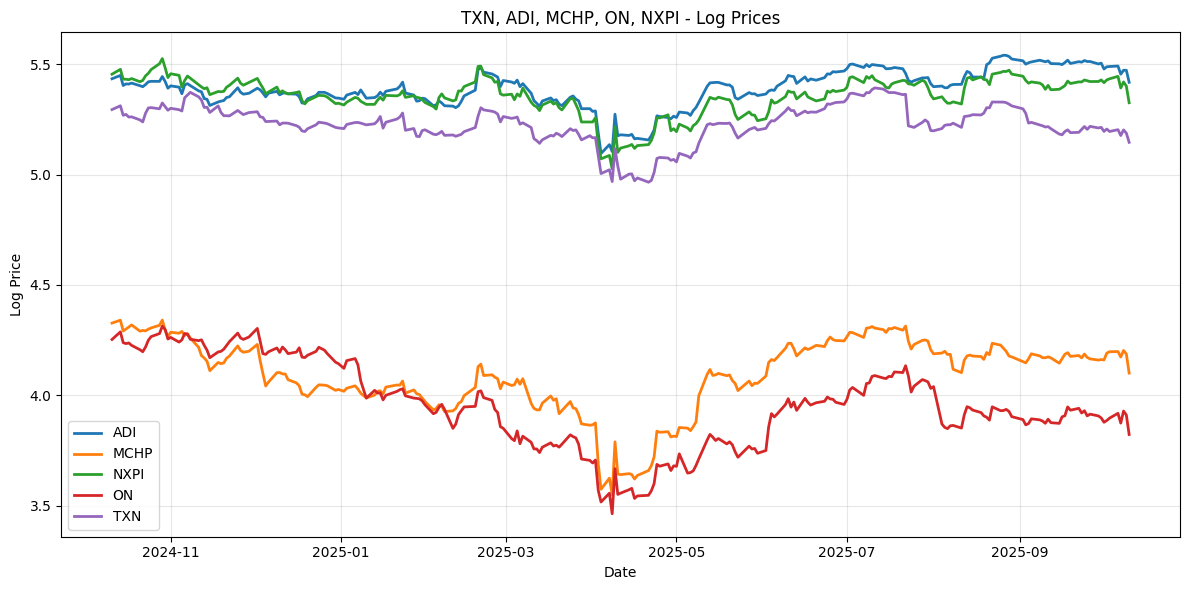

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*******************   40%                       ]  2 of 5 completed

[*********************100%***********************]  5 of 5 completed


Final dataset: 5 stocks
Basket: AMD, NVDA, AVGO, MRVL, QCOM
Cointegration rank: 0


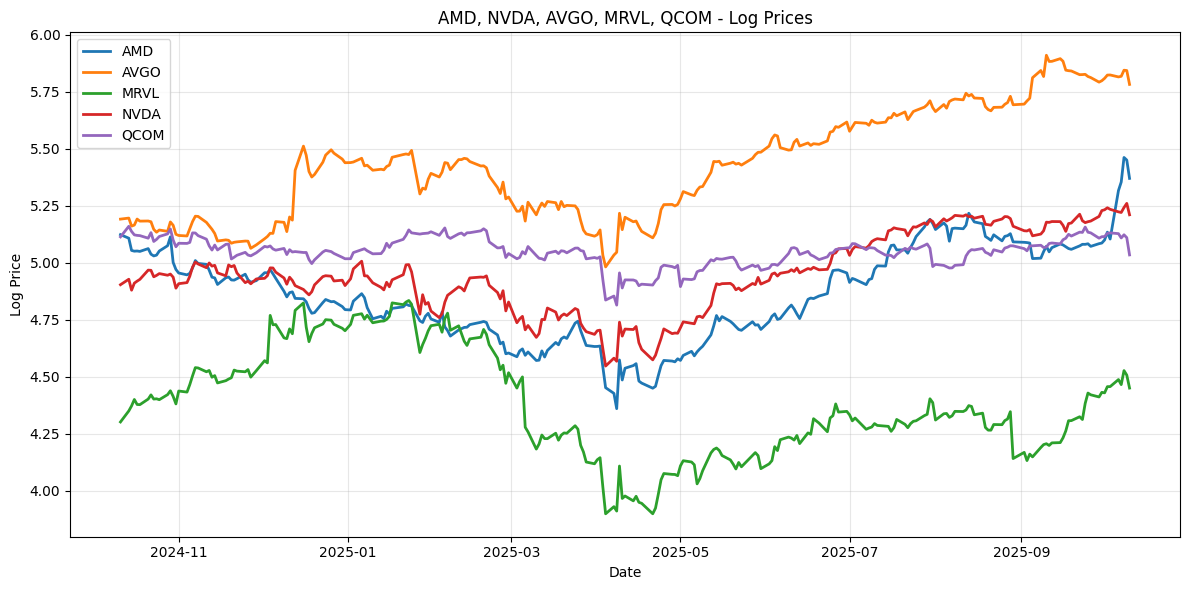

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed



Final dataset: 5 stocks
Basket: ZM, TWLO, DOCU, RNG, FIVN
Cointegration rank: 0


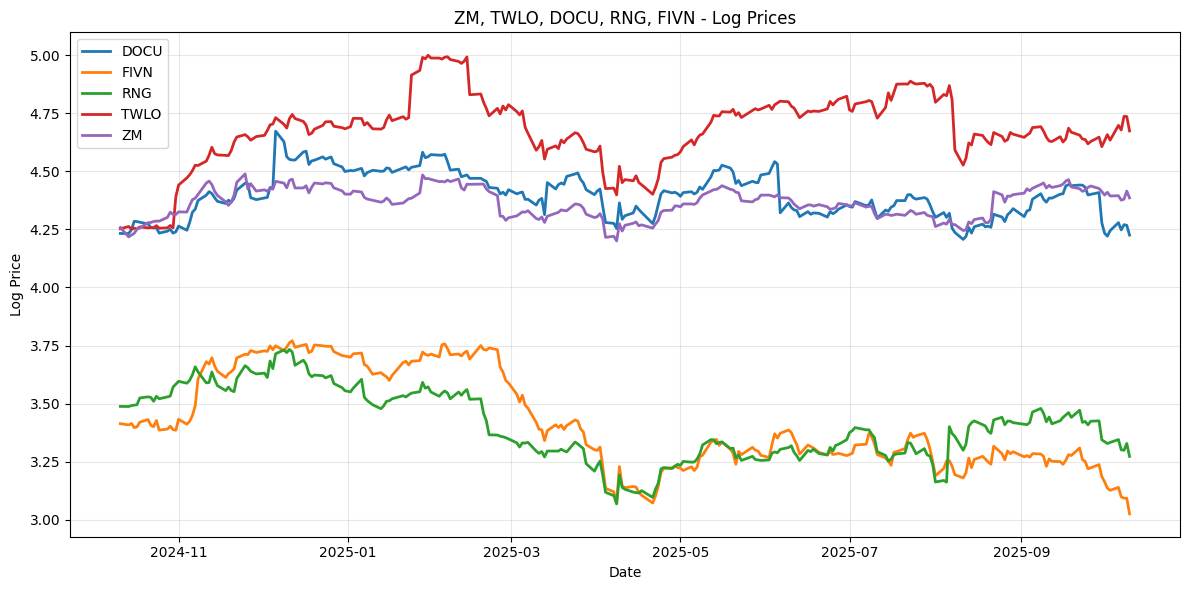

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*******************   40%                       ]  2 of 5 completed

[*********************100%***********************]  5 of 5 completed

1 Failed download:
['SQ']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 4 stocks
Basket: PYPL, SQ, BILL, SHOP, MELI
Cointegration rank: 0


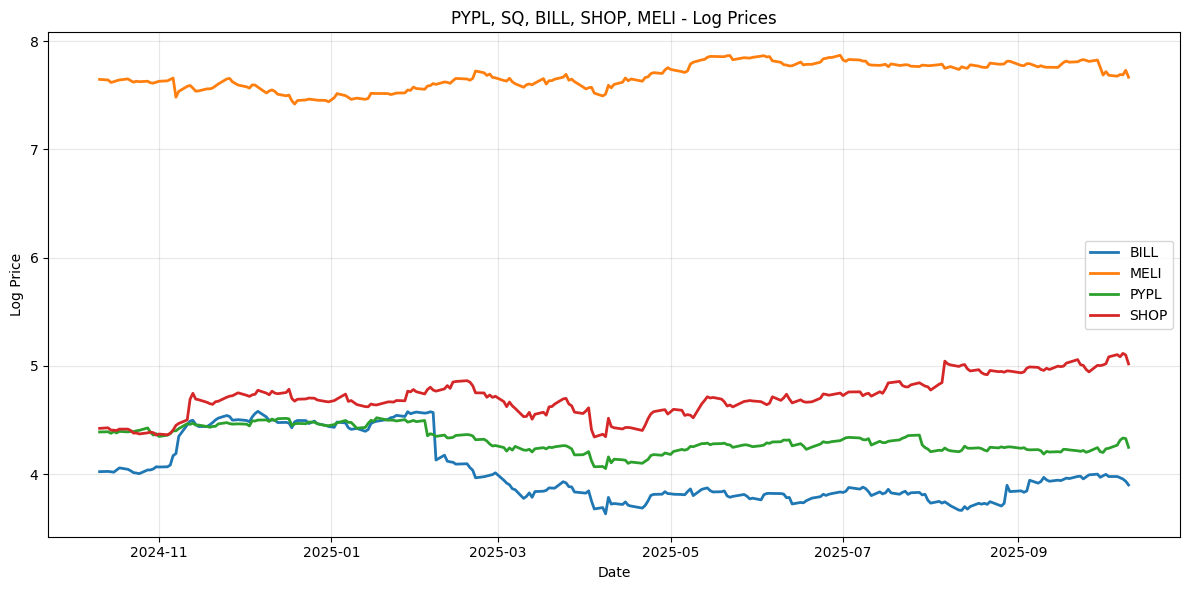

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed



Final dataset: 5 stocks
Basket: GTLB, FROG, PD, DOCN, CFLT
Cointegration rank: 1

Cointegrating vectors:
         Vector_1
Ticker           
CFLT    11.148591
DOCN     9.891542
FROG     4.069223
GTLB   -20.028994
PD       9.647208


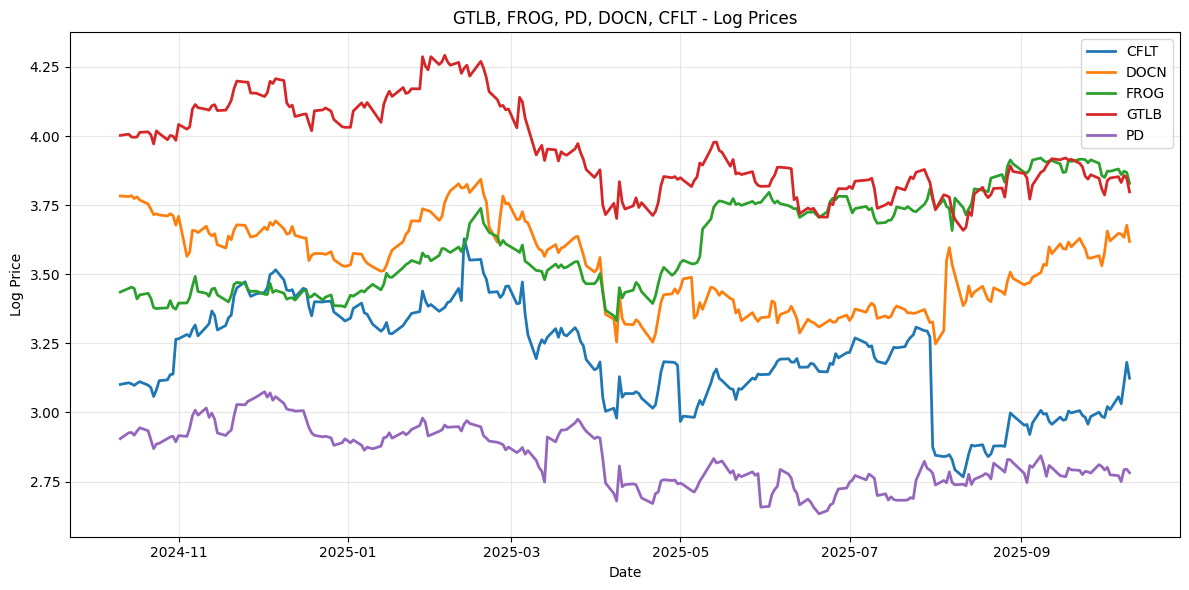

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*******************   40%                       ]  2 of 5 completed

[*********************100%***********************]  5 of 5 completed

2 Failed downloads:
['JNPR', 'VMW']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 3 stocks
Basket: CSCO, ANET, CIEN, JNPR, VMW
Cointegration rank: 0


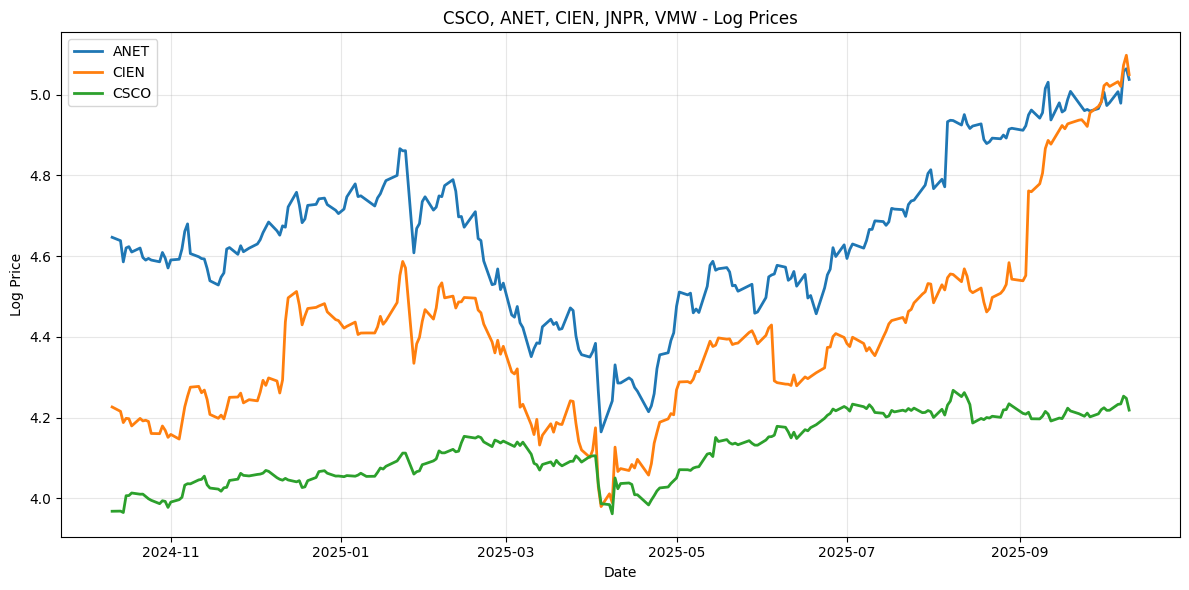

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

1 Failed download:
['BIGC']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 4 stocks
Basket: EBAY, WIX, BIGC, AMZN, U
Cointegration rank: 0


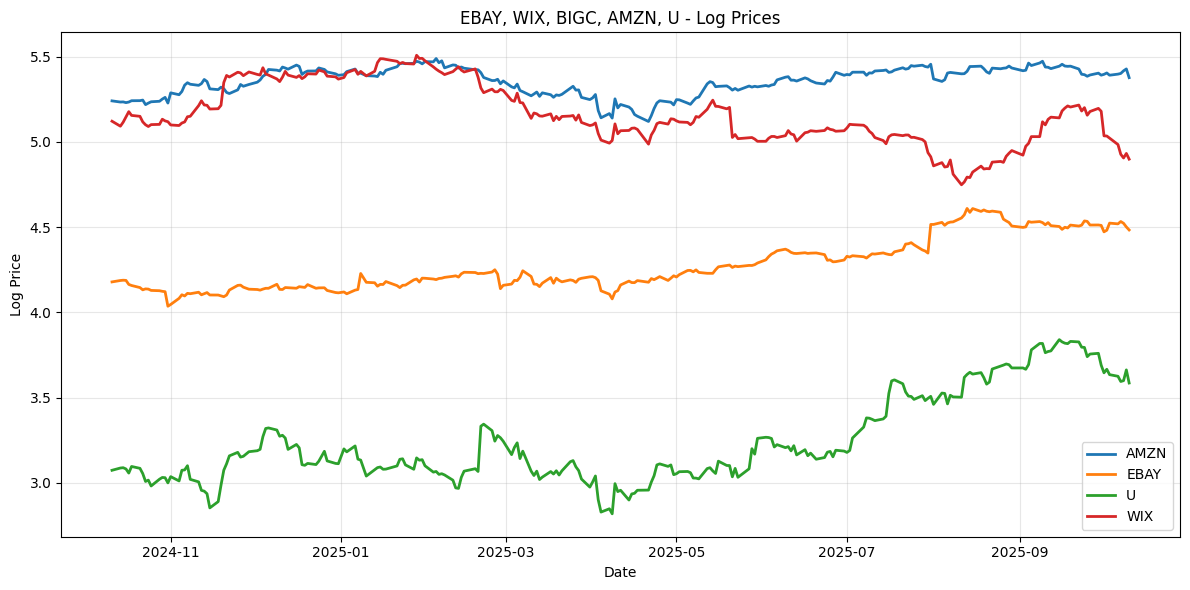

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  5 of 5 completed

Final dataset: 4 stocks
Basket: SAIL, VRNS, CYBR, TENB, CHKP
Cointegration rank: 3

Cointegrating vectors:
        Vector_1   Vector_2   Vector_3
Ticker                                
CHKP    2.213194 -16.384831  -3.388520
CYBR    4.384219   4.288761  -8.463117
TENB   -4.531261  -0.992628 -12.102371
VRNS   -6.533300  -9.058936   2.654524


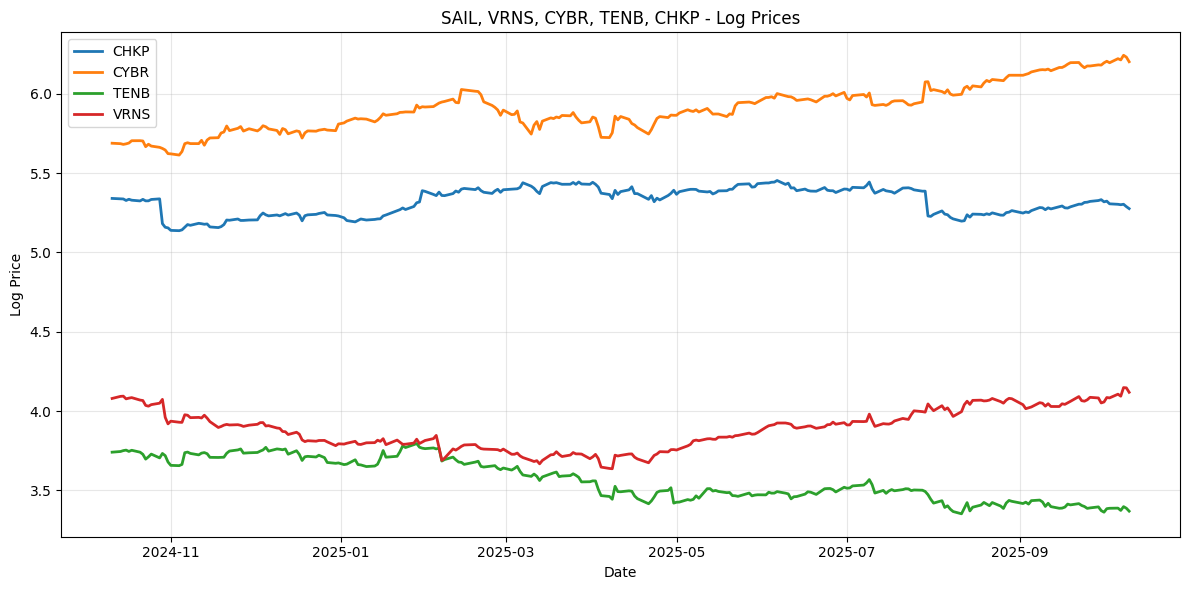

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed


Final dataset: 5 stocks
Basket: LRCX, KLAC, AMAT, ENTG, MPWR
Cointegration rank: 0


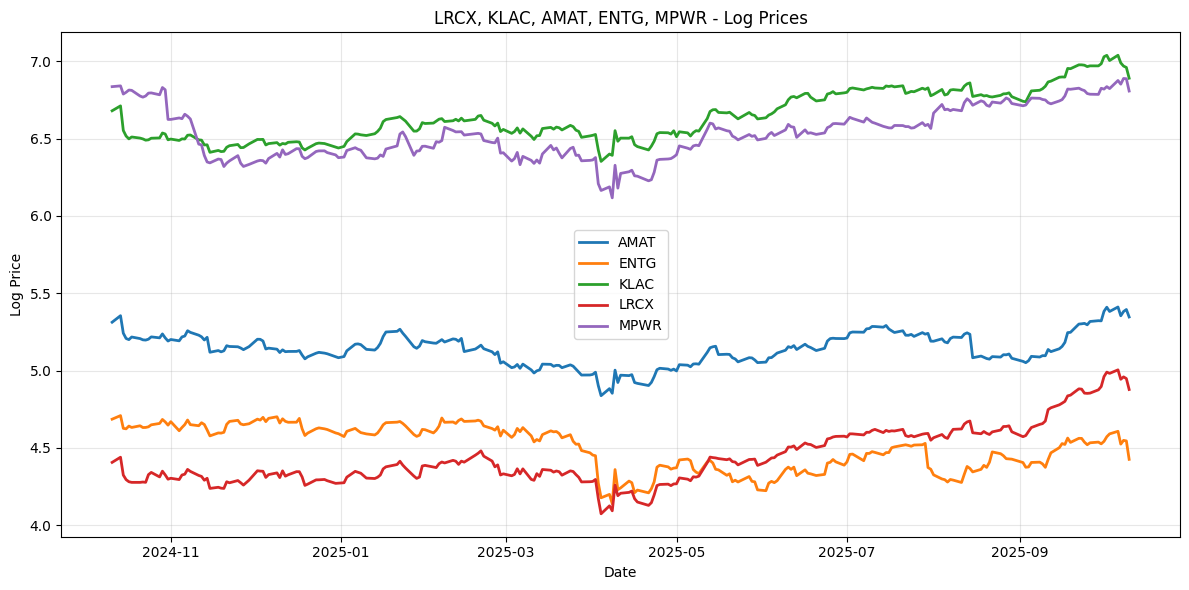

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


Final dataset: 5 stocks
Basket: META, PINS, SNAP, SPOT, ROKU
Cointegration rank: 0


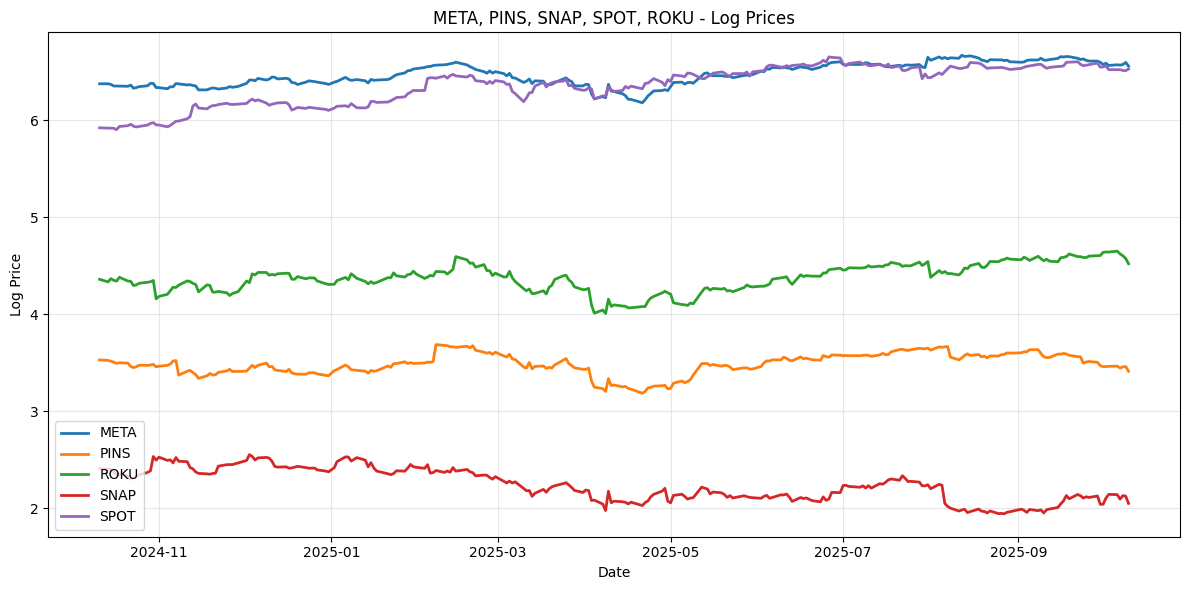

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

1 Failed download:
['SMAR']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


Final dataset: 4 stocks
Basket: ASAN, SMAR, DOMO, VEEV, PCTY
Cointegration rank: 0


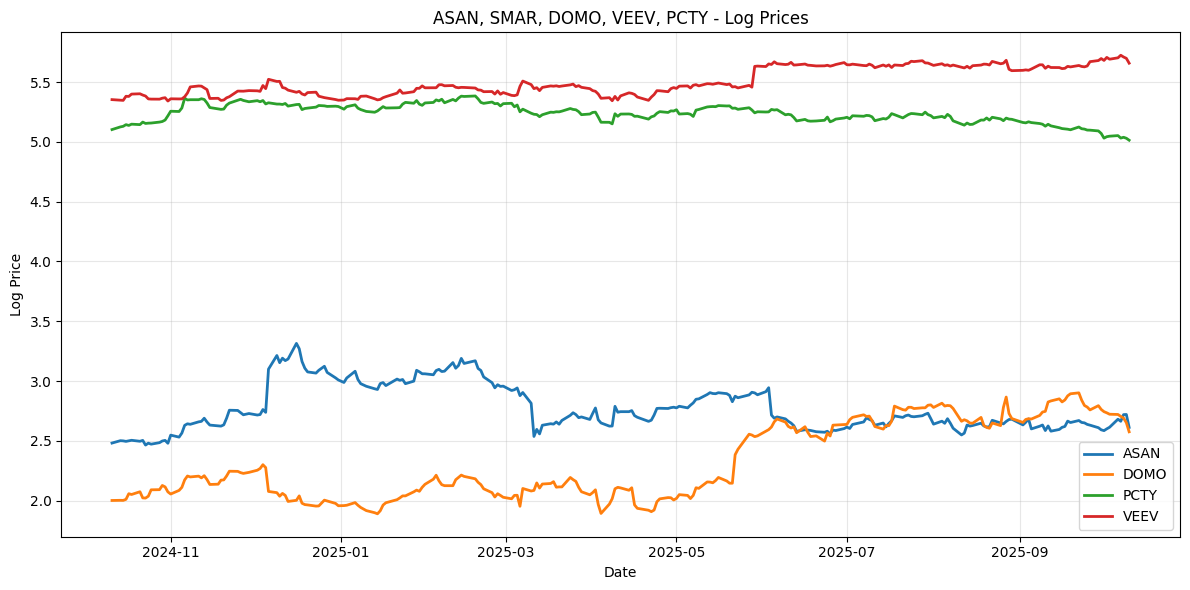

In [20]:
def analyze_multiple_baskets(basket_list, period="1y", crit_level=1, k_ar_diff=5):
    """Test multiple baskets at once"""
    for basket in basket_list:
        analyze_basket(basket, period, crit_level, k_ar_diff)
        print("\n" + "="*80 + "\n")

# Usage
analyze_multiple_baskets(all_baskets)

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed


Final dataset: 2 stocks

Running rolling cointegration for pair: DDOG vs NET
Window: 70 days, Total windows: 433



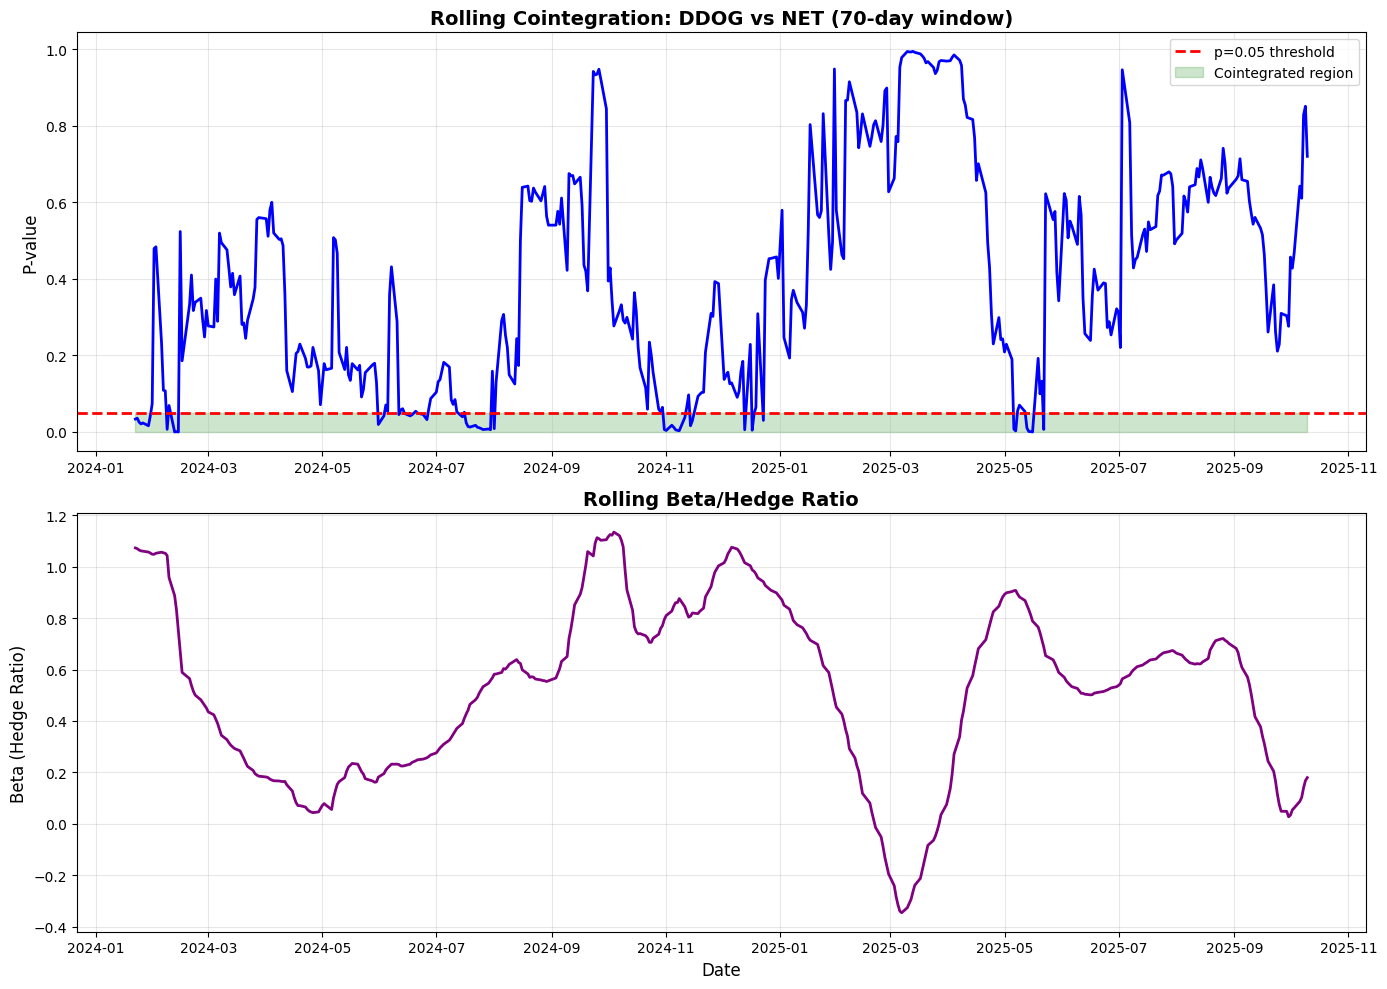

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  3 of 3 completed


Summary:
Cointegrated 12.5% of the time
Beta range: [-0.346, 1.135]
Beta mean: 0.520
Beta std: 0.341
Final dataset: 3 stocks

Running rolling cointegration for basket: DDOG, NET, SNOW
Window: 70 days, Total windows: 433



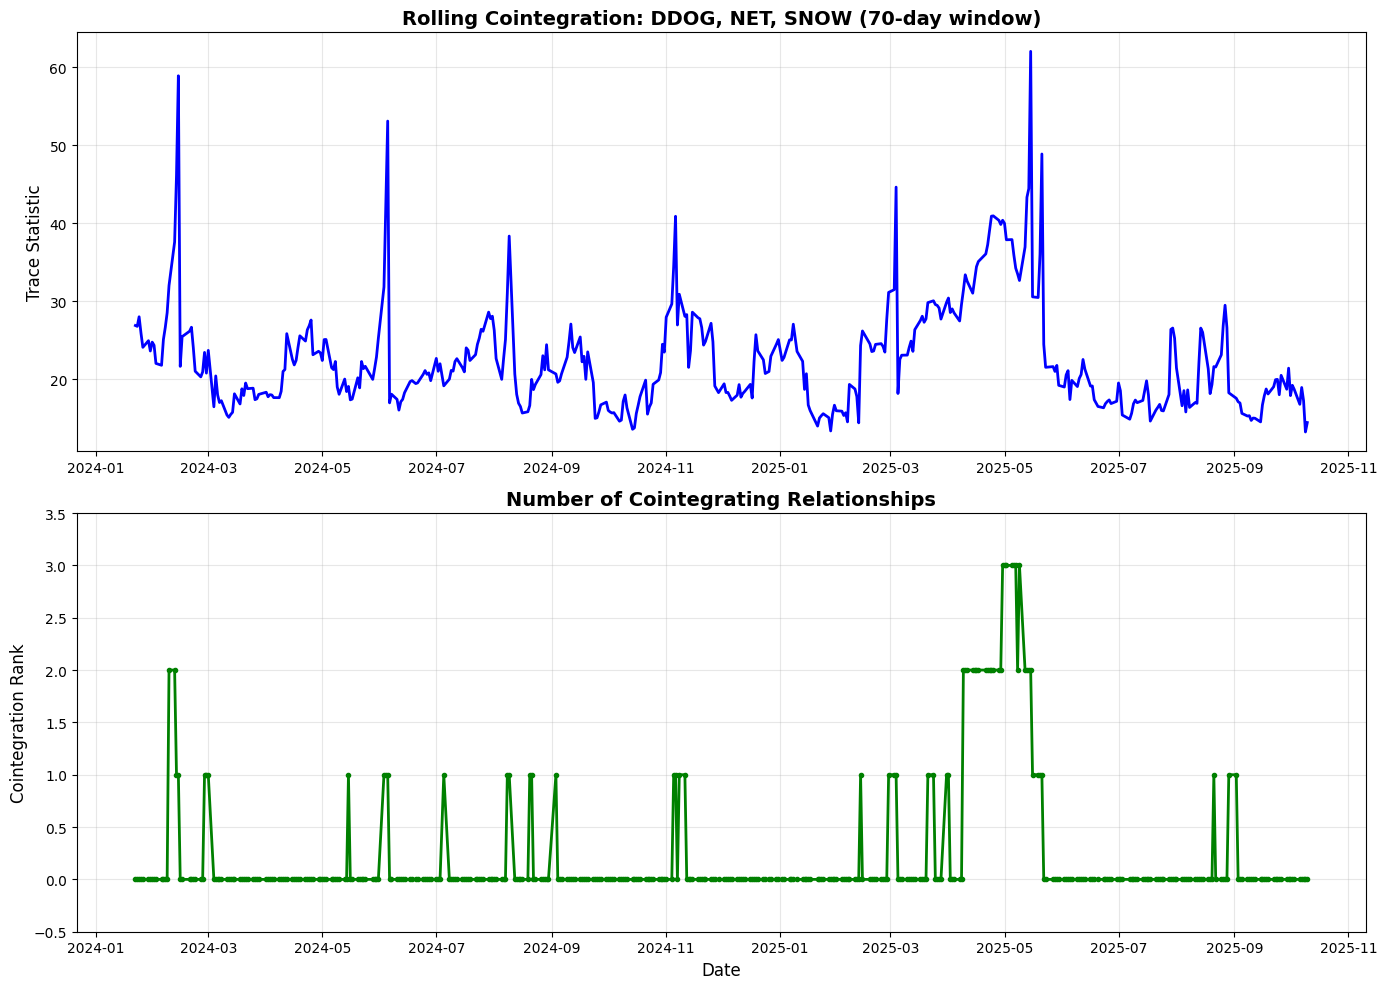


Summary:
Average cointegration rank: 0.22
Max rank observed: 3


C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed


Final dataset: 2 stocks

Running rolling cointegration for pair: DDOG vs NET
Window: 60 days, Total windows: 443



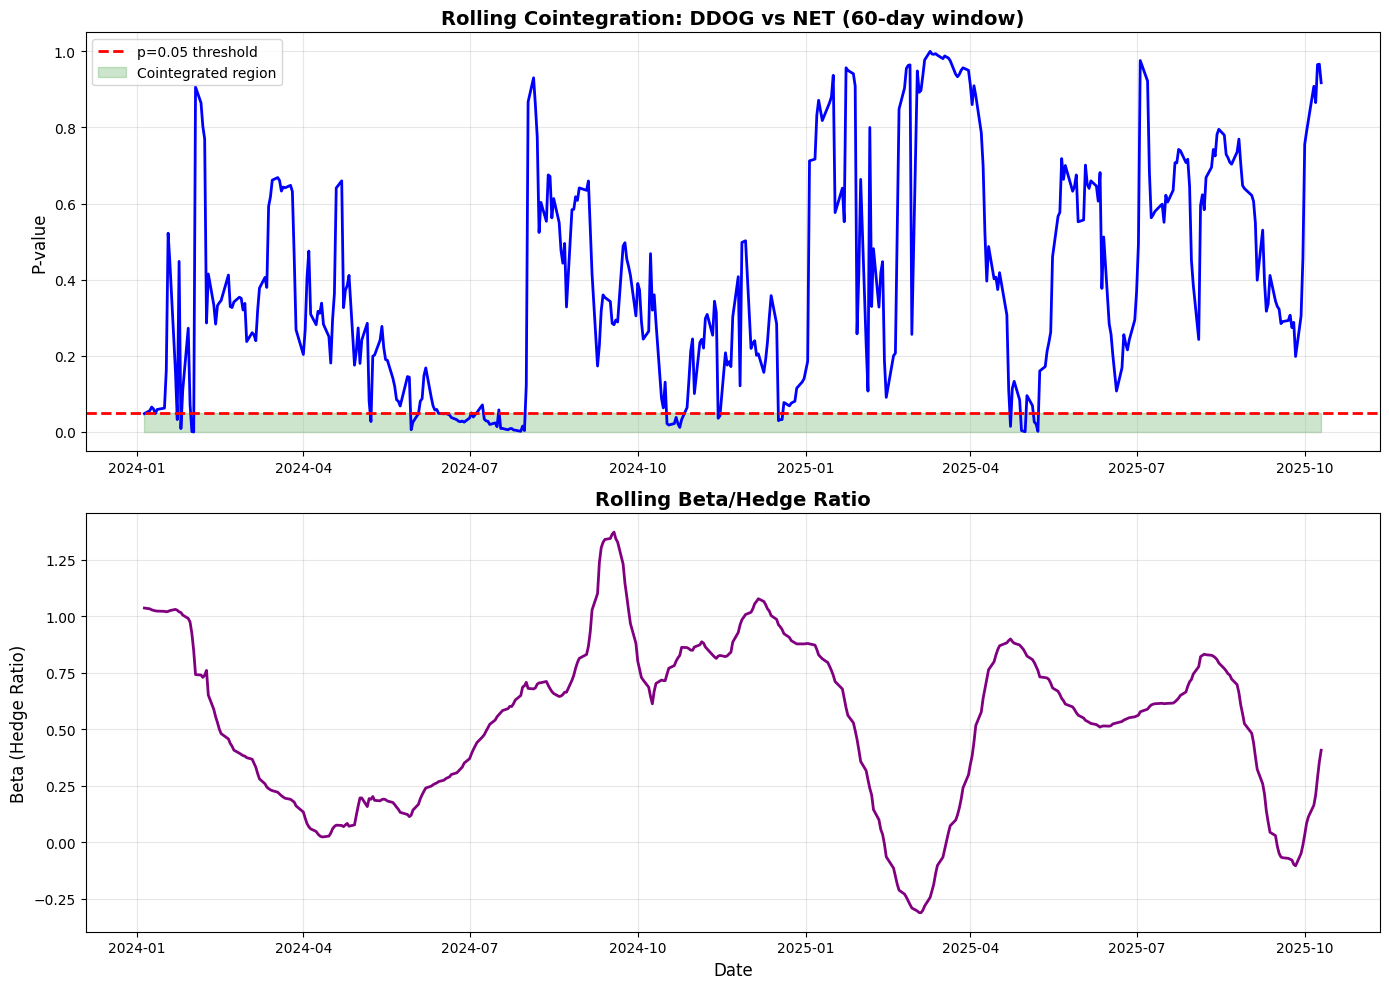

C:\Users\mgray\AppData\Local\Temp\ipykernel_52660\1234747663.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed


Summary:
Cointegrated 12.9% of the time
Beta range: [-0.311, 1.372]
Beta mean: 0.532
Beta std: 0.362
Final dataset: 2 stocks

Running rolling cointegration for pair: DDOG vs NET
Window: 90 days, Total windows: 413



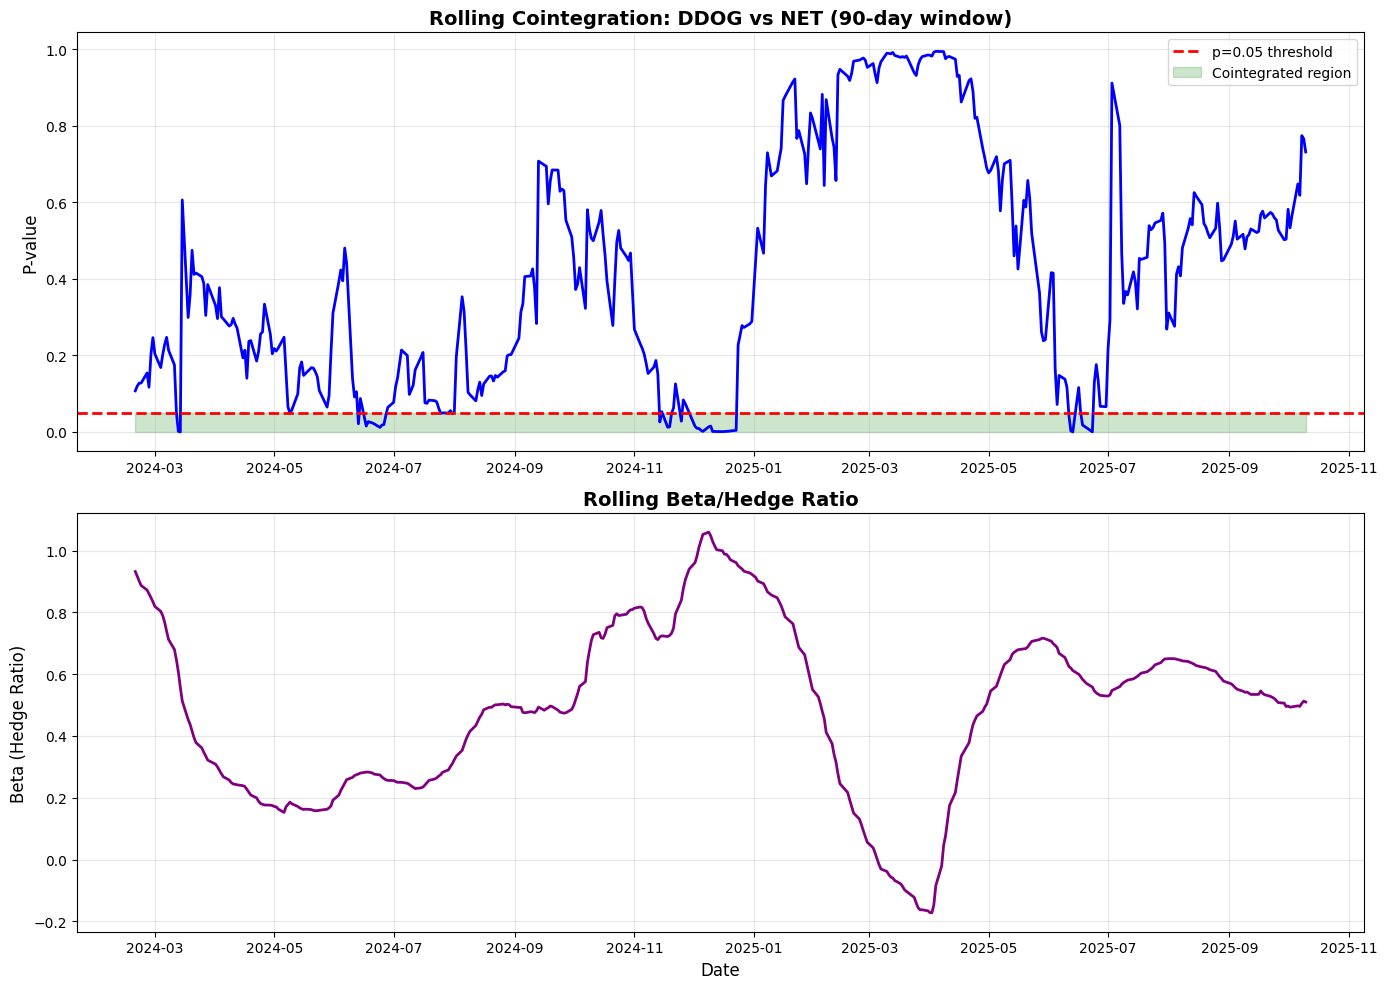


Summary:
Cointegrated 10.4% of the time
Beta range: [-0.172, 1.060]
Beta mean: 0.486
Beta std: 0.273


In [21]:
def rolling_cointegration_analysis(tickers, period="2y", window=70):
    """
    Rolling cointegration analysis for pairs or baskets
    
    Parameters:
    tickers: list of 2+ stock tickers
    period: "2y" for 2 years
    window: rolling window size (default 70 days)
    
    Returns:
    DataFrame with rolling test results
    """
    # Download data
    data = get_close_price_data(tickers, period=period)
    
    n_stocks = len(data.columns)
    n_windows = len(data) - window + 1
    
    results = []
    
    if n_stocks == 2:
        # PAIRS: Use Engle-Granger test
        stock_a = data.columns[0]
        stock_b = data.columns[1]
        
        print(f"\nRunning rolling cointegration for pair: {stock_a} vs {stock_b}")
        print(f"Window: {window} days, Total windows: {n_windows}\n")
        
        for i in range(window, len(data) + 1):
            start_idx = i - window
            end_idx = i
            
            window_data_a = data.iloc[start_idx:end_idx, 0]
            window_data_b = data.iloc[start_idx:end_idx, 1]
            
            # Engle-Granger test
            score, p_value, _ = coint(window_data_a, window_data_b)
            
            # Calculate beta from linear regression: A = beta * B + constant
            beta = np.polyfit(window_data_b, window_data_a, 1)[0]
            
            results.append({
                'date': data.index[end_idx - 1],
                'p_value': p_value,
                'beta': beta
            })
    
    else:
        # BASKETS: Use Johansen test
        print(f"\nRunning rolling cointegration for basket: {', '.join(data.columns)}")
        print(f"Window: {window} days, Total windows: {n_windows}\n")
        
        for i in range(window, len(data) + 1):
            start_idx = i - window
            end_idx = i
            
            window_data = data.iloc[start_idx:end_idx]
            
            # Johansen test
            result = coint_johansen(window_data, det_order=0, k_ar_diff=1)
            
            # Get cointegration rank at 95% confidence (index 1)
            coint_rank = sum(result.lr1 > result.cvt[:, 1])
            
            # Store max trace statistic (higher = stronger cointegration)
            max_trace = result.lr1[0] if len(result.lr1) > 0 else 0
            
            results.append({
                'date': data.index[end_idx - 1],
                'trace_stat': max_trace,
                'coint_rank': coint_rank
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('date', inplace=True)
    
    # Plot results
    if n_stocks == 2:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # P-value plot
        ax1.plot(results_df.index, results_df['p_value'], linewidth=2, color='blue')
        ax1.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
        ax1.fill_between(results_df.index, 0, 0.05, alpha=0.2, color='green', label='Cointegrated region')
        ax1.set_ylabel('P-value', fontsize=12)
        ax1.set_title(f'Rolling Cointegration: {stock_a} vs {stock_b} ({window}-day window)', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Beta plot
        ax2.plot(results_df.index, results_df['beta'], linewidth=2, color='purple')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Beta (Hedge Ratio)', fontsize=12)
        ax2.set_title('Rolling Beta/Hedge Ratio', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary stats
        pct_cointegrated = (results_df['p_value'] < 0.05).mean() * 100
        print(f"\nSummary:")
        print(f"Cointegrated {pct_cointegrated:.1f}% of the time")
        print(f"Beta range: [{results_df['beta'].min():.3f}, {results_df['beta'].max():.3f}]")
        print(f"Beta mean: {results_df['beta'].mean():.3f}")
        print(f"Beta std: {results_df['beta'].std():.3f}")
        
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Trace statistic plot
        ax1.plot(results_df.index, results_df['trace_stat'], linewidth=2, color='blue')
        ax1.set_ylabel('Trace Statistic', fontsize=12)
        ax1.set_title(f'Rolling Cointegration: {", ".join(data.columns)} ({window}-day window)', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Cointegration rank plot
        ax2.plot(results_df.index, results_df['coint_rank'], linewidth=2, color='green', marker='o', markersize=3)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Cointegration Rank', fontsize=12)
        ax2.set_title('Number of Cointegrating Relationships', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-0.5, n_stocks + 0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary stats
        avg_rank = results_df['coint_rank'].mean()
        print(f"\nSummary:")
        print(f"Average cointegration rank: {avg_rank:.2f}")
        print(f"Max rank observed: {results_df['coint_rank'].max()}")
    
    return results_df


# Usage examples:

# Test a pair
results_pair = rolling_cointegration_analysis(["NET", "DDOG"], window=70)

# Test a basket
results_basket = rolling_cointegration_analysis(["NET", "DDOG", "SNOW"], window=70)

# Try different window sizes
results_60 = rolling_cointegration_analysis(["NET", "DDOG"], window=60)
results_90 = rolling_cointegration_analysis(["NET", "DDOG"], window=90)